# Production Scheduling

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from pulp import LpVariable, LpProblem, LpMinimize, lpSum, LpStatusOptimal

In [2]:
df = pd.read_csv('../data/production.csv')
df.columns=['period', 'demand', 'fixed_cost', 'variable_cost', 'storage_cost', 'capacity']
df['time'] = range(1,13)
df.set_index('time', inplace=True)
df.head()

,period,demand,fixed_cost,variable_cost,storage_cost,capacity
time,,,,,,
1,period 1,3000,2000,40,1,4000
2,period 2,4000,2000,40,1,4000
3,period 3,2500,2000,40,1,4000
4,period 4,4000,2000,40,1,4000
5,period 5,6000,2000,40,1,4000


In [8]:
# Modify input variables
sensitive_capacity = range(2000, 8000, 1000)
sensitive_min_cost = []
sensitive_production = []
sensitive_inventory = []
sensitive_inproduction = []


for sensitivity_capacity in sensitive_capacity:
    df['capacity'] = sensitivity_capacity

    # inventory model variables
    inventory = LpVariable.dicts(name='inventory', indices=range(0,13), lowBound=0, upBound=None, cat='Integer')
    inventory[0] = 200

    # production model variables
    production = LpVariable.dicts(name='production', indices=range(1,13), lowBound=0, upBound=None, cat='Integer')

    # production status model variables
    in_production = LpVariable.dicts(name='inproduction', indices=range(1,13), lowBound=0, upBound=1, cat='Binary')

    # set time variable to match df index
    time = df.index

    # create model
    model = LpProblem(name='Production', sense=LpMinimize)

    # Objective function (minimize)
    model += lpSum( [ inventory[t]*df.loc[t,'storage_cost'] + 
                    production[t]*df.loc[t,'variable_cost'] + 
                    in_production[t]*df.loc[t,'fixed_cost'] 
                    for t in time] )
    
    # Constraints
    for t in time:
        model += production[t] - inventory[t]  + inventory[t-1] >= df.loc[t, 'demand']
        model += production[t] <= in_production[t] * df.loc[t, 'capacity']

    # Solve
    solution = model.solve()

    sensitive_min_cost.append(model.objective.value())  

    forecast_inventory=[]
    forecast_production=[]
    production_active=[]

    for i in time: 
        forecast_inventory.append(inventory[i].value())
        forecast_production.append(production[i].value())
        production_active.append(in_production[i].value())

    sensitive_production.append({f'Production (C={sensitivity_capacity})': forecast_production})
    sensitive_inventory.append({f'Inventory (C={sensitivity_capacity})': forecast_inventory})
    sensitive_inproduction.append({f'Production Active (C={sensitivity_capacity})': production_active})

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


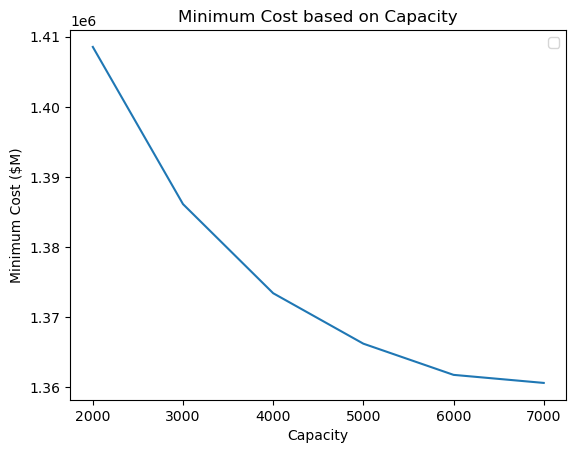

In [9]:
# Visualize Results
plt.plot(sensitive_capacity, sensitive_min_cost )
plt.xlabel('Capacity')
plt.ylabel('Minimum Cost ($M)')
plt.title('Minimum Cost based on Capacity')
plt.legend()

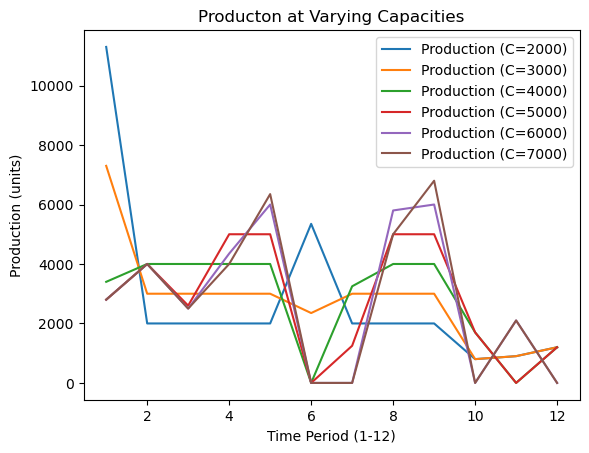

In [10]:
for prod in sensitive_production:
    plt.plot(time, list(prod.values())[0], label=f'{list(prod.keys())[0]}')

plt.xlabel('Time Period (1-12)')
plt.ylabel('Production (units)')
plt.title('Producton at Varying Capacities')
plt.legend()

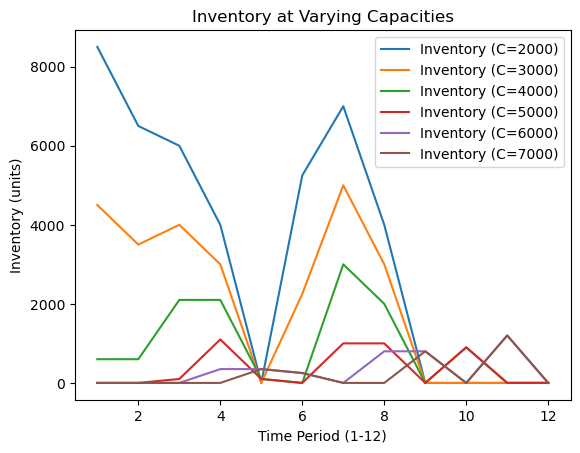

In [11]:
for inv in sensitive_inventory:
    plt.plot(time, list(inv.values())[0], label=f'{list(inv.keys())[0]}')

plt.xlabel('Time Period (1-12)')
plt.ylabel('Inventory (units)')
plt.title('Inventory at Varying Capacities')
plt.legend()

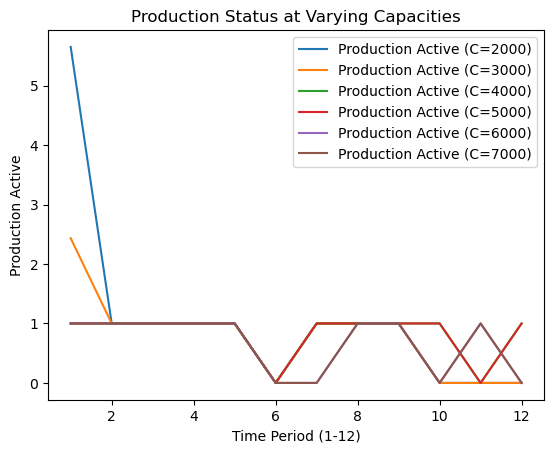

In [12]:
for inv in sensitive_inproduction:
    plt.plot(time, list(inv.values())[0], label=f'{list(inv.keys())[0]}')

plt.xlabel('Time Period (1-12)')
plt.ylabel('Production Active')
plt.title('Production Status at Varying Capacities')
plt.legend()